In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math 

In [2]:
def load(fname):
    with open(fname) as fin:
        return np.array([list(map(float, s[:-1].split(','))) for s in fin.readlines()])

In [3]:
def show_data(data):
    for [x,y,label] in data:
        plt.plot(x,y, 'bo' if label < 0.5 else 'ro')
    plt.show()

In [4]:
def getMinkowskiDistance(p):
    return lambda a, b : sum(abs(a - b) ** p) ** (1 / p)

In [31]:
class kNN:
    def __init__(self, data, k = 5, p = 2):
        self.k = k
        self.p = p
        self.data = data
        
    def solve(self, x):
        ro = getMinkowskiDistance(self.p)
        d = sorted(self.data, key = lambda z: ro(x,z[:-1]))
        classes = {}
        for i in range(self.k):
            classes.setdefault(d[i][-1], 0)
            classes[d[i][-1]] += 1
        
        mx = max(classes.values())
        for c in classes:
            if classes[c] == mx:
                return c 

In [32]:
def f(x, y):
    return y if x < 1 else 0
def uniform(x):
    return f(x, 0.5)
def triangle(x):
    return f(x, 1 - x)
def epanechnikov(x):
    return f(x, 3 / 4 * (1 - x ** 2))
def quartic(x):
    return f(x, 15 / 16 * (1 - x ** 2) ** 2)
def triweight(x):
    return f(x, 35 / 32 * (1 - x ** 2) ** 3)
def gaussian(x):
    return math.e ** (-1 / 2 * x ** 2) / (2 * math.pi) ** 0.5
def cosine(x):
    return f(x, math.pi / 4 * math.cos(x / 2 * math.pi))

In [7]:
class PRWindow:        
    def __init__(self, data, k = 5, p = 2, kernel = uniform):
        self.data = data
        self.k = k
        self.p = p
        self.kernel = kernel
    
    def getC(self, x):
        ro = getMinkowskiDistance(self.p)
        d = sorted(self.data, key = lambda z: ro(x, z[:-1]))
        classes = {}
        for xi in d:
            classes.setdefault(xi[-1], 0)
            classes[xi[-1]] += self.kernel(ro(x, xi[:-1]) / ro(x, d[self.k][:-1]))
        
        return classes

    
    def fit(self, x):
        classes = self.getC(x)
        return max([(classes[cl], cl) for cl in classes])[1]
    
    def margin(self, x, y):
        classes = self.getC(x)
        return classes[y] - max([(classes[cl], cl) for cl in classes if cl != y])[0]
        


In [8]:
def show_model():
    b, d = data.max(axis=0)[:-1]
    a, c = data.min(axis=0)[:-1]
    
    n = 25
    
    for i in range(n):
        for j in range(n):
            x, y = a + (b - a) / n * i, c + (d - c) / n * j
            rs = knn.solve([x, y])
            plt.plot(x, y, 'b+' if rs < 0.5 else 'r+')
    plt.show()

In [9]:
def L(model, x):
    return int(model.fit(x[:-1]) != x[-1])

def Q(model, xs):
    return sum(map(lambda p: L(model, p), xs)) / len(xs)

def CV(model, t):
    step = len(data) / t
    err = 0
    for i in range(t):
        l, r = int(step * i), int(step * (i + 1))
        model.data = np.append(data[ : l], data[r : ], axis = 0)
        err += Q(model, data[l : r])
    return err / t

In [10]:
def setk(model, k, t):
    model.k = k
    return CV(model, t)

def grid_search(model, ks, t):
    return ks[np.array(list(map(lambda k: setk(model, k, t), ks))).argmin()]

In [11]:
data = load('chips.txt')

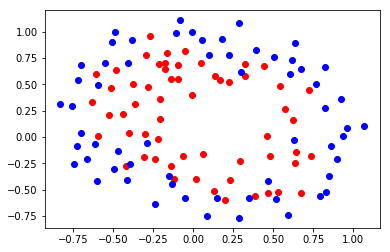

In [12]:
show_data(data)

In [143]:
seed = np.random.randint(1, 100)
seed

40

In [144]:
testsize = 40
train, test = train_test_split(data, train_size = len(data) - testsize, test_size = testsize, random_state = seed)

In [145]:
knn = PRWindow(train, p = 2)
bestk = grid_search(knn, range(1, 20, 2), len(data) - testsize)

In [146]:
knn.data = train
knn.k = bestk
print(bestk)

7


In [147]:
Q(knn, test)

0.25

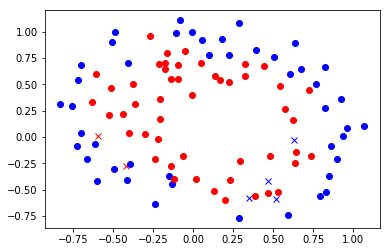

In [23]:
ms = []
for i in range(len(train)):
    knn.data = np.append(train[:i], train[i + 1:], axis = 0)
    m = knn.margin(train[i][:-1], train[i][-1])
    ms.append(m)
    if m <= -1:
        plt.plot(train[i][0], train[i][1], 'bx' if train[i][-1] < 0.5 else 'rx')
    else:
        plt.plot(train[i][0], train[i][1], 'bo' if train[i][-1] < 0.5 else 'ro')
#list(map(print, sorted(zip(map(lambda x: (x[0], x[1], x[2]), train), ms))))
plt.show()

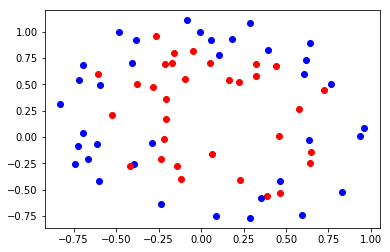

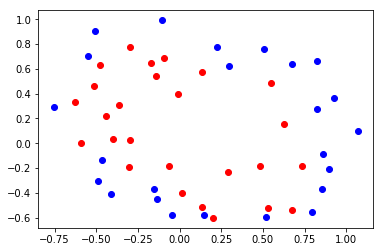

In [97]:
show_data(train)
show_data(test)